<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/6Sates_clusteringCountyData_SocialDist(X1)_Mobility(X2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=4f7af6e352100b7864c30e2e1ab5ac64bd9ecee71c660dfbda899fc5abb459cf
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import pandas as pd
import wget 
from PIL import Image

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load USA State Fips Code

In [4]:
state_fips_code = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/US_State_FIPSCodes.csv',low_memory=False)
state_fips_code.head()

,State,Postal Code,STFIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


# Load Social Distancing Inertia Data [Maryland University]

In [5]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/County_Oct13.csv',low_memory=False)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,1/1/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,1/2/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,1/3/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,1/4/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,1/5/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [6]:
maryland_sd_inertia['STFIPS'].unique()

array([ 1,  2,  4,  5,  6,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

## Fixdate column of Social Distancing inertia

In [7]:
def fixDate(x, appendTwenty):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  if appendTwenty == True:
    return '20'+y+'-'+m+'-'+d
  else:
      return y+'-'+m+'-'+d

In [8]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(lambda x: fixDate(x,False))
maryland_sd_inertia.reset_index(drop=True)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0000,0.00,0,47.100000,0.0,0.00,0.00,0,0,0.00,0,0.9,2.7,3.2,0.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901749,56045,Weston County,56,40,20,3.00,27.4,10.3,172.4,0.04,2.96,3,6967,-16.3,2020-10-09,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.50,0,38.319241,6.6,191.28,1.32,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901750,56045,Weston County,56,37,22,3.37,26.1,10.3,90.4,0.11,3.26,4,6967,-7.8,2020-10-10,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3828,5.65,0,38.321286,6.7,191.49,1.33,3,29,9.69,0,1.2,9.3,18.5,1.51,0.96
901751,56045,Weston County,56,42,26,2.70,24.5,13.1,71.9,0.06,2.64,0,6967,-25.3,2020-10-11,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.3349,5.81,0,38.323483,6.9,191.76,1.33,3,25,9.69,0,1.2,9.3,18.5,1.51,0.96
901752,56045,Weston County,56,26,19,3.05,25.3,9.9,102.7,0.04,3.00,0,6967,-15.2,2020-10-12,8.34,30,52867,0.5,1.5,53.07,3,1,153,3.76,0.50,0.017,0.1914,6.08,0,38.324928,7.0,192.09,1.33,3,24,9.69,0,1.2,9.3,18.5,1.51,0.96


In [ ]:
maryland_sd_inertia.head(3)

,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [9]:
maryland_sd_inertia.columns

Index(['CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemploy

## Assign State Name

California, New York, Texas, Iowa, Wisconsin, Colorado

In [10]:
maryland_sd_inertia = pd.merge(state_fips_code,maryland_sd_inertia,how='inner',left_on=['STFIPS'],right_on=['STFIPS'])
print(maryland_sd_inertia.shape)

maryland_sd_inertia.head(2)

(901467, 45)


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate
0,Alabama,AL,1,1001,Autauga County,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,AL,1,1001,Autauga County,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


## Filter Data for 6 States

In [11]:
state_list = ['California', 'New York', 'Texas', 'Iowa', 'Wisconsin', 'Colorado']

maryland_sd_inertia_6states = maryland_sd_inertia[maryland_sd_inertia['State'].isin(state_list)]
print(maryland_sd_inertia_6states.head(3) )

            State Postal Code  ...  Cumulative inflation rate  COVID death rate
53382  California          CA  ...                        0.3               0.0
53383  California          CA  ...                        0.3               0.0
53384  California          CA  ...                        0.3               0.0

[3 rows x 45 columns]


In [12]:
maryland_sd_inertia_6states.State.unique()

array(['California', 'Colorado', 'Iowa', 'New York', 'Texas', 'Wisconsin'],
      dtype=object)

## Group Columns

In [13]:
maryland_sd_inertia_6states.columns

Index(['State', 'Postal Code', 'STFIPS', 'CTFIPS', 'CTNAME',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people', 'New cases/1000 people',
       'Active cases/1000 people', '#days: decreasing COVID cases',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 p

In [14]:
X_cols = ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate','New cases/1000 people']

#Y_col = ['New cases/1000 people']


In [19]:
#social distancing
X1_cols = ['Social distancing index','New cases/1000 people']

#mobility
X2_cols = ['% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','Transit mode share','% working from home','New cases/1000 people']

X3_cols = ['% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density','New cases/1000 people']  
   
X4_vols = ['# hot spots/1000 people',
       '# contact tracing workers/1000 people',
        'Testing capacity',
       'Tests done/1000 people', 
       'Imported COVID cases', 'COVID exposure/1000 people', 
       'New cases/1000 people']

X5_cols = ['Hospital beds/1000 people', 'ICUs/1000 people','#days: decreasing ILI cases',
           '% hospital bed utilization','% ICU utilization', 'Ventilator shortage','New cases/1000 people']

        


In [16]:
# have to check which values are NA
maryland_sd_inertia_6states_filtered = maryland_sd_inertia_6states.dropna()

# Filter Data

In [17]:
n_classes = 3
training_inputs = maryland_sd_inertia_6states_filtered[X2_cols].values
#training_outputs_labels = [c for row in maryland_sd_inertia_6states[Y_col].values for c in row]
print(training_inputs.shape)

(139769, 10)


# K-means clustering

In [18]:
from sklearn.cluster import KMeans


y_kmeans = KMeans(n_clusters=7,init ='k-means++', max_iter=300, n_init=10,random_state=0 ).fit_predict(training_inputs)

X = training_inputs

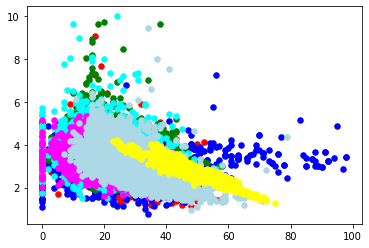

In [20]:
#6 Visualising the clusters
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=30, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=30, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=30, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=30, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=30, c='magenta', label ='Cluster 5')
plt.scatter(X[y_kmeans==5, 0], X[y_kmeans==5, 1], s=30, c='lightblue', label ='Cluster 6')
plt.scatter(X[y_kmeans==6, 0], X[y_kmeans==6, 1], s=30, c='yellow', label ='Cluster 7')

In [21]:
y_kmeans

array([1, 3, 3, ..., 2, 0, 4], dtype=int32)

# GMM Clustering

In [22]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [23]:
#predictions from gmm
labels = gmm.predict(training_inputs)
frame = pd.DataFrame(training_inputs)
frame['cluster'] = labels
frame_columns = ['% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','Transit mode share','% working from home','New cases/1000 people','cluster']

frame.columns = frame_columns 


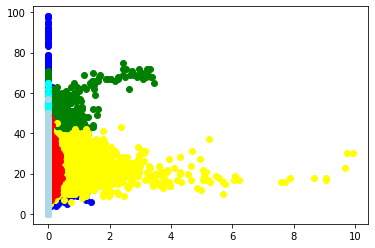

In [25]:

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame[frame["cluster"]==k]
    plt.scatter(data['New cases/1000 people'],data["% staying home"],c=color[k])
plt.show()

# K-means Cosine create,visualize

ref: https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

In [27]:
X = training_inputs

#For X2 - Mobility Columns
X_cols = X2_cols

In [28]:
len(X_cols)

10

In [29]:
X.shape

(139769, 10)

## Elbow Curve

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


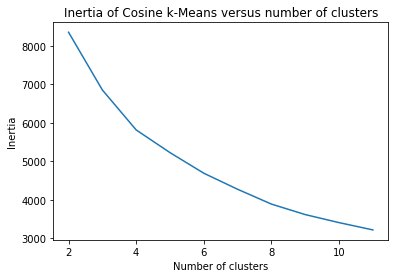

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


normalized_vectors = preprocessing.normalize(X)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

## silhouette score - Run Kmeans

In [54]:
normalized_vectors = preprocessing.normalize(X)
#change cluster number here
normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)

print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))


Cosine kmeans:0.4010806713515443


In [55]:
normalized_vectors.shape

(139769, 10)

In [56]:
#print(min_samples)
print(X.shape)


(139769, 10)


### Helper methods

In [57]:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 


def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()
    
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

### Visualization

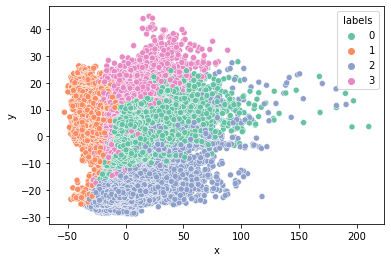

In [58]:
pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")

In [59]:
for label in pca_df.labels.unique():
  print("label", label, "  shape",pca_df[pca_df.labels == label].shape)

label 2   shape (36344, 3)
label 3   shape (41179, 3)
label 0   shape (41502, 3)
label 1   shape (20744, 3)


* label 0   shape (116731, 3)
* label 4   shape (21589, 3)
* label 1   shape (574, 3)
* label 2   shape (287, 3)
* label 3   shape (588, 3)

## Cluster note:

* We have cluster 1,2,3 with minimal data, hence we are applying fractal clustering only for cluster 0,4

In [ ]:
def rename_cluster_label(x, prefix = 'cluster_'):
  return prefix+str(x)


In [ ]:
maryland_sd_inertia_6states_filtered['cluster'] = pca_df.labels.to_list()
maryland_sd_inertia_6states_filtered.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster
226156,Iowa,IA,19,19001,Adair County,51,31,2.39,59.9,15.9,44.7,0.21,2.18,0,7063,-26.9,2020-01-01,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0
226157,Iowa,IA,19,19001,Adair County,15,18,3.68,55.5,12.0,72.5,0.37,3.31,0,7063,11.0,2020-01-02,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0


In [ ]:
maryland_sd_inertia_6states_filtered['cluster_label'] = maryland_sd_inertia_6states_filtered['cluster'].apply(rename_cluster_label)
maryland_sd_inertia_6states_filtered.head(3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster,cluster_label
226156,Iowa,IA,19,19001,Adair County,51,31,2.39,59.9,15.9,44.7,0.21,2.18,0,7063,-26.9,2020-01-01,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0,cluster_0
226157,Iowa,IA,19,19001,Adair County,15,18,3.68,55.5,12.0,72.5,0.37,3.31,0,7063,11.0,2020-01-02,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0,cluster_0
226158,Iowa,IA,19,19001,Adair County,14,18,3.54,57.8,14.1,82.1,0.43,3.11,0,7063,4.3,2020-01-03,0.34,31,51859,0.4,1.9,49.35,12,5,169,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0,cluster_0


## Retaining small clusters

In [ ]:
data_final1 = maryland_sd_inertia_6states_filtered[(maryland_sd_inertia_6states_filtered['cluster'] == 1) |
                                                   (maryland_sd_inertia_6states_filtered['cluster'] == 2) | 
                                                   (maryland_sd_inertia_6states_filtered['cluster'] == 3) ]

data_final1.shape

(1449, 47)

## Fractal clustering - Util functions

In [ ]:
maryland_sd_inertia_6states_filtered_ = maryland_sd_inertia_6states_filtered.copy()

In [ ]:
def fractal_clustering(df, cluster_label = 0,n_clusters=5):
    df_filtered = df[df['cluster'] == cluster_label]
    training_inputs = df_filtered[X_cols].values

    X = training_inputs
    normalized_vectors = preprocessing.normalize(training_inputs)
    normalized_kmeans = KMeans(n_clusters=5).fit(normalized_vectors)
    print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))
    
    pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
    sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")
    
    df_filtered['cluster'] = pca_df.labels.to_list()
  
    return df_filtered

## Iteration 1: Fractal clustering : Cluster 0 (Cluster_0_)

In [ ]:
maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['cluster'] == 0].shape

(116731, 47)

Cosine kmeans:0.7389382920829424


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(116731, 47)

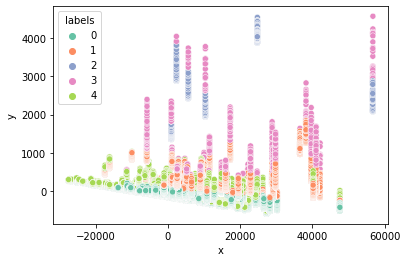

In [ ]:
df_cluster1 = fractal_clustering(maryland_sd_inertia_6states_filtered, cluster_label=0,n_clusters=5)
df_cluster1.shape

In [ ]:
for label in df_cluster1.cluster.unique():
  print("label", label, "  shape",df_cluster1[df_cluster1.cluster == label].shape)

label 0   shape (97888, 47)
label 1   shape (8410, 47)
label 3   shape (751, 47)
label 4   shape (8540, 47)
label 2   shape (1142, 47)


In [ ]:
df_cluster1['cluster_label'] = df_cluster1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_'))
df_cluster1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(116731, 47)

In [ ]:
data_final2 = df_cluster1[(df_cluster1['cluster'] == 2) | (df_cluster1['cluster'] == 3)]
data_final2.shape

(1893, 47)

### Cluster note:

* From the above shape, we will apply fractal cluster to 
 
 1.  cluster 0
 2.  cluster 1 
 3.  cluster 4

## Iteration 2: Fractal clustering : Cluster 0- cluster 1 (Cluster_0_1_)




Cosine kmeans:0.44201766330418424
(8410, 47)
label 0   shape (2283, 47)
label 3   shape (1540, 47)
label 1   shape (2516, 47)
label 4   shape (1060, 47)
label 2   shape (1011, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



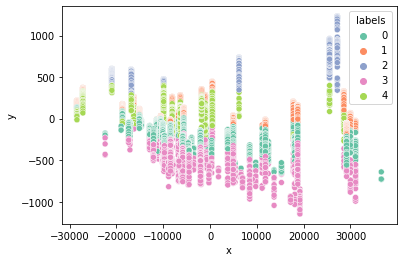

In [ ]:
df_cluster0_1 = fractal_clustering(df_cluster1, cluster_label=1,n_clusters=5)
print(df_cluster0_1.shape)

for label in df_cluster0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_1[df_cluster0_1.cluster == label].shape)

In [ ]:
df_cluster0_1['cluster_label'] = df_cluster0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_1_'))
df_cluster0_1.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(8410, 47)

In [ ]:
data_final3 = df_cluster0_1.copy()
print(data_final3.shape)
data_final3.tail()

(8410, 47)


,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster,cluster_label
894861,Wisconsin,WI,55,55141,Wood County,28,21,3.52,33.9,0.8,43.7,0.50,3.02,45,73055,6.7,2020-10-09,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.4106,10.54,0,48.993310,9.1,287.48,14.44,179,617,18.65,133,2.1,9.9,19.7,2.1,1.33,3,cluster_0_1_3
894862,Wisconsin,WI,55,55141,Wood County,31,23,3.19,34.1,0.9,54.3,0.34,2.85,30,73055,0.7,2020-10-10,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.4608,10.74,0,49.408011,9.2,290.00,14.63,188,583,18.65,133,2.1,9.9,19.7,2.1,1.33,3,cluster_0_1_3
894863,Wisconsin,WI,55,55141,Wood County,40,29,2.64,35.8,1.3,49.1,0.57,2.06,26,73055,-27.2,2020-10-11,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.4608,10.96,0,49.843670,9.3,291.76,14.44,199,510,18.65,133,2.1,9.9,19.7,2.1,1.33,3,cluster_0_1_3
894864,Wisconsin,WI,55,55141,Wood County,32,23,2.87,35.1,1.0,40.9,0.53,2.34,18,73055,-17.4,2020-10-12,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.3376,11.07,0,50.300740,9.4,293.46,15.13,209,534,18.65,133,2.1,9.9,19.7,2.1,1.33,3,cluster_0_1_3
894865,Wisconsin,WI,55,55141,Wood County,31,21,3.02,32.5,0.6,44.6,0.53,2.49,20,73055,-12.1,2020-10-13,0.2,26,53473,0.6,2.9,49.21,91,54,145,3.01,0.27,0.045,0.2920,11.35,0,48.555679,9.5,295.98,15.32,174,544,18.65,133,2.1,9.9,19.7,2.1,1.33,3,cluster_0_1_3


## Iteration 2: Fractal clustering : Cluster 0- cluster 0 (cluster_0_0_)

Cosine kmeans:0.5627614133663322


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(97888, 47)
label 1   shape (49688, 47)
label 0   shape (20869, 47)
label 2   shape (17013, 47)
label 3   shape (6517, 47)
label 4   shape (3801, 47)


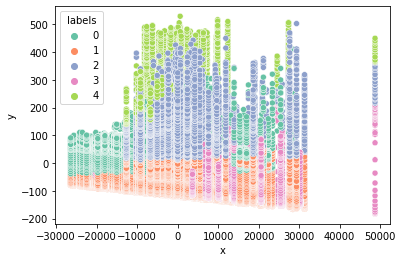

In [ ]:
df_cluster2 = fractal_clustering(df_cluster1, cluster_label=0,n_clusters=5)
print(df_cluster2.shape)

for label in df_cluster2.cluster.unique():
  print("label", label, "  shape",df_cluster2[df_cluster2.cluster == label].shape)

### Cluster Note:

1. Cluster 1 - 6504
2. Cluster 2 - 49691
3. Cluster 3 - 17003
4. Cluster 4 - 20872

In [ ]:
df_cluster2['cluster_label'] = df_cluster2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final4 = df_cluster2[df_cluster2['cluster'] == 4]
data_final4.shape

(3801, 47)

## FC :: Cluster 0_0_3

Cosine kmeans:0.3289538402756109
(6517, 47)
label 1   shape (1491, 47)
label 4   shape (832, 47)
label 3   shape (2272, 47)
label 0   shape (1399, 47)
label 2   shape (523, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



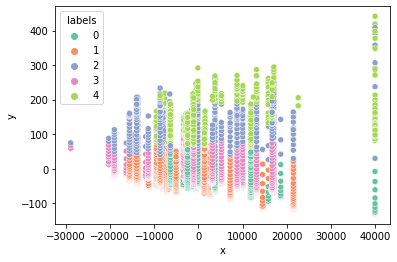

In [ ]:
df_cluster0_0_3 = fractal_clustering(df_cluster2, cluster_label=3,n_clusters=5)
print(df_cluster0_0_3.shape)

for label in df_cluster0_0_3.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_3[df_cluster0_0_3.cluster == label].shape)

In [ ]:
df_cluster0_0_3['cluster_label'] = df_cluster0_0_3['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_3_'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final5 = df_cluster0_0_3.copy()
data_final5.shape

(6517, 47)

## FC:: Cluster 0_0_1

Cosine kmeans:0.3187698633657458


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(49688, 47)
label 4   shape (12236, 47)
label 0   shape (12763, 47)
label 1   shape (18872, 47)
label 2   shape (2719, 47)
label 3   shape (3098, 47)


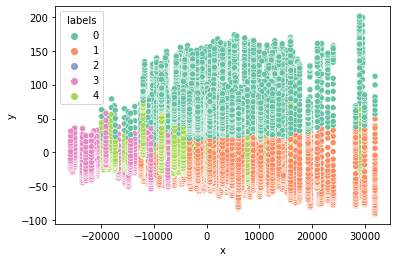

In [ ]:
df_cluster0_0_1 = fractal_clustering(df_cluster2, cluster_label=1,n_clusters=5)
print(df_cluster0_0_1.shape)

for label in df_cluster0_0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_1[df_cluster0_0_1.cluster == label].shape)

In [ ]:
df_cluster0_0_1['cluster_label'] = df_cluster0_0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_'))
df_cluster0_0_1.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(49688, 47)

In [ ]:
data_final6 = df_cluster0_0_1[(df_cluster0_0_1['cluster'] == 2) | (df_cluster0_0_1['cluster'] == 3)]

data_final6.shape

(5817, 47)

## FC:: Cluster 0_0_1_0

Cosine kmeans:0.34951319187321195
(12763, 47)
label 2   shape (2800, 47)
label 0   shape (3317, 47)
label 3   shape (2112, 47)
label 4   shape (2152, 47)
label 1   shape (2382, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



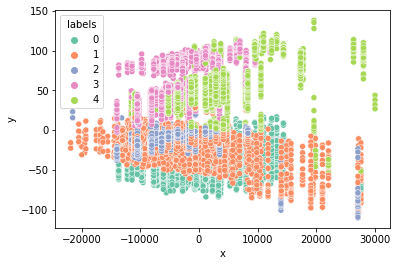

In [ ]:
df_cluster0_0_1_0 = fractal_clustering(df_cluster0_0_1, cluster_label=0,n_clusters=5)
print(df_cluster0_0_1_0.shape)

for label in df_cluster0_0_1_0.cluster.unique():

  print("label", label, "  shape",df_cluster0_0_1_0[df_cluster0_0_1_0.cluster == label].shape)

In [ ]:
df_cluster0_0_1_0['cluster_label'] = df_cluster0_0_1_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_0_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final7 = df_cluster0_0_1_0.copy()
data_final7.shape

(12763, 47)

## FC:: Cluster 0_0_1_4

Cosine kmeans:0.3181705869578569
(12236, 47)
label 0   shape (5764, 47)
label 2   shape (2338, 47)
label 1   shape (1209, 47)
label 4   shape (2853, 47)
label 3   shape (72, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



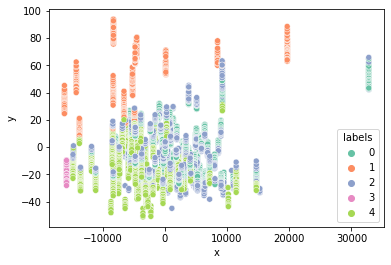

In [ ]:
df_cluster0_0_1_4 = fractal_clustering(df_cluster0_0_1, cluster_label=4,n_clusters=5)
print(df_cluster0_0_1_4.shape)

for label in df_cluster0_0_1_4.cluster.unique():
  
  print("label", label, "  shape",df_cluster0_0_1_4[df_cluster0_0_1_4.cluster == label].shape)

In [ ]:
df_cluster0_0_1_4['cluster_label'] = df_cluster0_0_1_4['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_4_'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final8 = df_cluster0_0_1_4[(df_cluster0_0_1_4['cluster'] == 1) | (df_cluster0_0_1_4['cluster'] == 2) | 
                                (df_cluster0_0_1_4['cluster'] == 3) | (df_cluster0_0_1_4['cluster'] == 4)]
data_final8.shape       

(6472, 47)

#### FC :: Cluster 0_0_1_4_0

Cosine kmeans:0.33917121762004093
(5764, 47)
label 3   shape (987, 47)
label 1   shape (2473, 47)
label 0   shape (245, 47)
label 2   shape (1629, 47)
label 4   shape (430, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



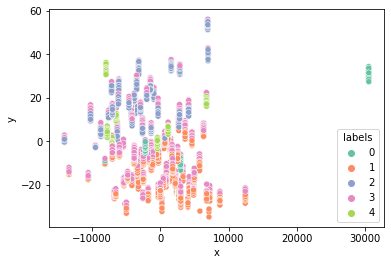

In [ ]:
df_cluster0_0_1_4_0 = fractal_clustering(df_cluster0_0_1_4, cluster_label=0,n_clusters=5)
print(df_cluster0_0_1_4_0.shape)

for label in df_cluster0_0_1_4_0.cluster.unique():
  
  print("label", label, "  shape",df_cluster0_0_1_4_0[df_cluster0_0_1_4_0.cluster == label].shape)

In [ ]:


df_cluster0_0_1_4_0['cluster_label'] = df_cluster0_0_1_4_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_4_0_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final9 = df_cluster0_0_1_4_0.copy()
data_final9.shape

(5764, 47)

## FC:: Cluster 0_0_1_1

Cosine kmeans:0.27699468845541975


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(18872, 47)
label 0   shape (2138, 47)
label 2   shape (6983, 47)
label 4   shape (2866, 47)
label 1   shape (3129, 47)
label 3   shape (3756, 47)


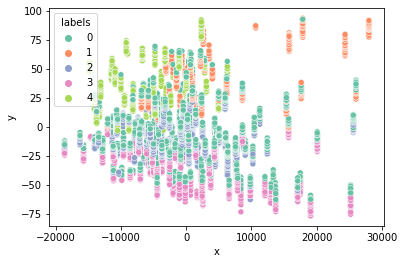

In [ ]:
df_cluster0_0_1_1 = fractal_clustering(df_cluster0_0_1, cluster_label=1,n_clusters=5)
print(df_cluster0_0_1_1.shape)

for label in df_cluster0_0_1_1.cluster.unique():
  
  print("label", label, "  shape",df_cluster0_0_1_1[df_cluster0_0_1_1.cluster == label].shape)

In [ ]:
df_cluster0_0_1_1['cluster_label'] = df_cluster0_0_1_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_1_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final10 = df_cluster0_0_1_1[(df_cluster0_0_1_1['cluster'] == 0) |(df_cluster0_0_1_1['cluster'] == 1) | 
                                 (df_cluster0_0_1_1['cluster'] == 3) | (df_cluster0_0_1_1['cluster'] == 4)]
data_final10.shape                      

(11889, 47)

### FC:: Cluster 0_0_1_1_2

Cosine kmeans:0.2298220823865171


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(6983, 47)
label 0   shape (1864, 47)
label 2   shape (999, 47)
label 3   shape (1810, 47)
label 4   shape (960, 47)
label 1   shape (1350, 47)


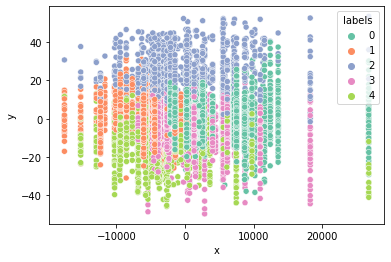

In [ ]:
df_cluster0_0_1_1_2 = fractal_clustering(df_cluster0_0_1_1, cluster_label=2,n_clusters=5)
print(df_cluster0_0_1_1_2.shape)

for label in df_cluster0_0_1_1_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_1_1_2[df_cluster0_0_1_1_2.cluster == label].shape)

In [ ]:
df_cluster0_0_1_1_2['cluster_label'] = df_cluster0_0_1_1_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_1_1_2_'))
df_cluster0_0_1_1_2.head(2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster,cluster_label
227592,Iowa,IA,19,19011,Benton County,14,16,3.78,38.6,1.1,48.4,0.74,3.05,0,25642,4.5,2020-01-02,0.19,24,65475,0.6,1.4,49.88,36,8,129,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0,cluster_0_0_1_1_2_0
227593,Iowa,IA,19,19011,Benton County,13,16,3.81,39.0,1.1,60.1,0.68,3.13,0,25642,7.2,2020-01-03,0.19,24,65475,0.6,1.4,49.88,36,8,129,3.69,0.26,0.011,0.0,0.0,0,30.0,0.0,0.0,0.0,0,0,0.0,0,1.6,2.8,4.8,0.2,0.0,0,cluster_0_0_1_1_2_0


In [ ]:
data_final11 = df_cluster0_0_1_1_2.copy()
data_final11.shape

(6983, 47)

## FC:: Cluster 0_0_0

Cosine kmeans:0.2854098897040357


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(20869, 47)
label 1   shape (6544, 47)
label 0   shape (1812, 47)
label 3   shape (6820, 47)
label 4   shape (3947, 47)
label 2   shape (1746, 47)


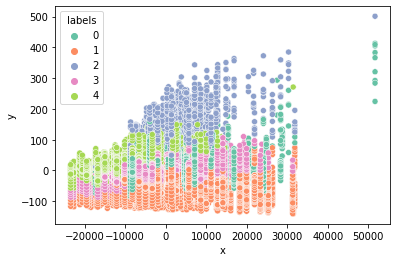

In [ ]:
df_cluster0_0_0 = fractal_clustering(df_cluster2, cluster_label=0,n_clusters=5)
print(df_cluster0_0_0.shape)

for label in df_cluster0_0_0.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_0[df_cluster0_0_0.cluster == label].shape)

In [ ]:
df_cluster0_0_0['cluster_label'] = df_cluster0_0_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_0_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final12 = df_cluster0_0_0[(df_cluster0_0_0['cluster'] == 0 )|
                               (df_cluster0_0_0['cluster'] == 2) |
                               (df_cluster0_0_0['cluster'] == 4)]

data_final12.shape                               

(7505, 47)

### FC:: Cluster 0_0_0_1

Cosine kmeans:0.3083701873214841
(6544, 47)
label 2   shape (512, 47)
label 3   shape (1499, 47)
label 1   shape (2082, 47)
label 4   shape (910, 47)
label 0   shape (1541, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



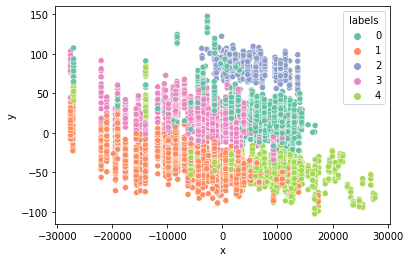

In [ ]:
df_cluster0_0_0_1 = fractal_clustering(df_cluster0_0_0, cluster_label=1,n_clusters=5)
print(df_cluster0_0_0_1.shape)

for label in df_cluster0_0_0_1.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_0_1[df_cluster0_0_0_1.cluster == label].shape)

In [ ]:


df_cluster0_0_0_1['cluster_label'] = df_cluster0_0_0_1['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_0_1_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final13 = df_cluster0_0_0_1.copy()
data_final13.shape

(6544, 47)

### FC:: Cluster 0_0_0_3

Cosine kmeans:0.2658243031501517
(6820, 47)
label 2   shape (1893, 47)
label 4   shape (1822, 47)
label 3   shape (1216, 47)
label 1   shape (816, 47)
label 0   shape (1073, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



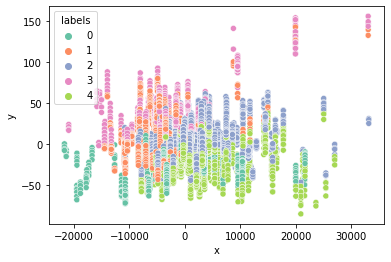

In [ ]:
df_cluster0_0_0_3 = fractal_clustering(df_cluster0_0_0, cluster_label=3,n_clusters=5)
print(df_cluster0_0_0_3.shape)

for label in df_cluster0_0_0_3.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_0_3[df_cluster0_0_0_3.cluster == label].shape)

In [ ]:


df_cluster0_0_0_3['cluster_label'] = df_cluster0_0_0_3['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_0_3_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final14 = df_cluster0_0_0_3.copy()
data_final14.shape

(6820, 47)

## FC:: Cluster 0_0_2

Cosine kmeans:0.3475263260497737
(17013, 47)
label 4   shape (5064, 47)
label 2   shape (5478, 47)
label 3   shape (3219, 47)
label 0   shape (1797, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



label 1   shape (1455, 47)


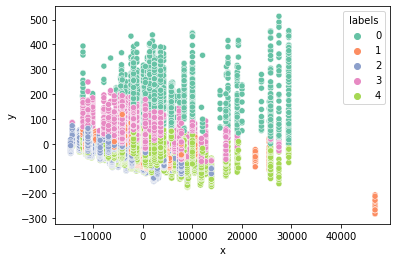

In [ ]:
df_cluster0_0_2 = fractal_clustering(df_cluster2, cluster_label=2,n_clusters=5)
print(df_cluster0_0_2.shape)

for label in df_cluster0_0_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2[df_cluster0_0_2.cluster == label].shape)

In [ ]:
df_cluster0_0_2['cluster_label'] = df_cluster0_0_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final15 = df_cluster0_0_2[df_cluster0_0_2['cluster'] == 0]
data_final15.shape

(1797, 47)

### FC:: Cluster 0_0_2_4

Cosine kmeans:0.3072404560818559
(5064, 47)
label 0   shape (1545, 47)
label 1   shape (1301, 47)
label 2   shape (317, 47)
label 3   shape (1181, 47)
label 4   shape (720, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



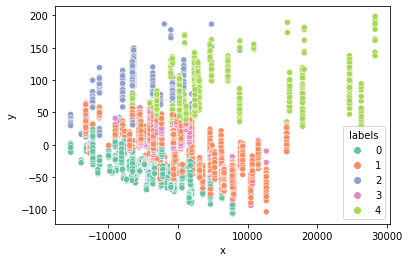

In [ ]:
df_cluster0_0_2_4 = fractal_clustering(df_cluster0_0_2, cluster_label=4,n_clusters=5)
print(df_cluster0_0_2_4.shape)

for label in df_cluster0_0_2_4.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2_4[df_cluster0_0_2_4.cluster == label].shape)

In [ ]:
df_cluster0_0_2_4['cluster_label'] = df_cluster0_0_2_4['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_4_'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final16 = df_cluster0_0_2_4.copy()
data_final16.shape

(5064, 47)

### FC :: Cluster 0_0_2_2

Cosine kmeans:0.31279788384569107
(5478, 47)
label 4   shape (1188, 47)
label 0   shape (1774, 47)
label 3   shape (1369, 47)
label 1   shape (752, 47)
label 2   shape (395, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



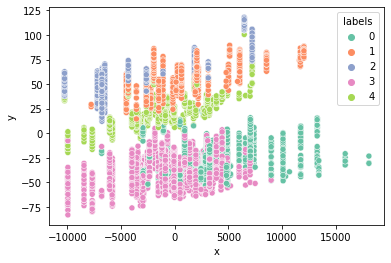

In [ ]:
df_cluster0_0_2_2 = fractal_clustering(df_cluster0_0_2, cluster_label=2,n_clusters=5)
print(df_cluster0_0_2_2.shape)

for label in df_cluster0_0_2_2.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2_2[df_cluster0_0_2_2.cluster == label].shape)

In [ ]:
df_cluster0_0_2_2['cluster_label'] = df_cluster0_0_2_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_2_'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final17 = df_cluster0_0_2_2.copy()
data_final17.shape

(5478, 47)

### FC :: Cluster 0_0_2_3

Cosine kmeans:0.3802095250077735
(3219, 47)
label 3   shape (924, 47)
label 0   shape (391, 47)
label 1   shape (765, 47)
label 4   shape (767, 47)
label 2   shape (372, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



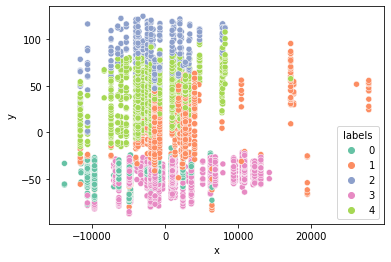

In [ ]:
df_cluster0_0_2_3 = fractal_clustering(df_cluster0_0_2, cluster_label=3,n_clusters=5)
print(df_cluster0_0_2_3.shape)

for label in df_cluster0_0_2_3.cluster.unique():
  print("label", label, "  shape",df_cluster0_0_2_3[df_cluster0_0_2_3.cluster == label].shape)

In [ ]:
df_cluster0_0_2_3['cluster_label'] = df_cluster0_0_2_3['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_0_2_3_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final18 = df_cluster0_0_2_3.copy()
data_final18.shape

(3219, 47)

## Iteration 2: Fractal Clustering : Cluster 0 - cluster 4 cluster_0_4_

Cosine kmeans:0.4657453013147312
(8540, 47)
label 1   shape (1059, 47)
label 2   shape (666, 47)
label 3   shape (2591, 47)
label 0   shape (2141, 47)
label 4   shape (2083, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



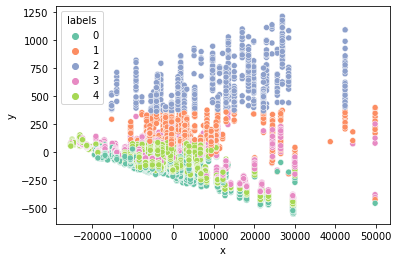

In [ ]:
df_cluster_0_4 = fractal_clustering(df_cluster1, cluster_label=4,n_clusters=5)
print(df_cluster_0_4.shape)

for label in df_cluster_0_4.cluster.unique():
  print("label", label, "  shape",df_cluster_0_4[df_cluster_0_4.cluster == label].shape)

In [ ]:
df_cluster_0_4['cluster_label'] = df_cluster_0_4['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_0_4_'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final19 = df_cluster_0_4.copy()
data_final19.shape

(8540, 47)

## Iteration 1: Fractal clustering:  Cluster 4 (cluster_4_)

Cosine kmeans:0.6179176851059847


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(21589, 47)
label 1   shape (10135, 47)
label 0   shape (7518, 47)
label 2   shape (1366, 47)
label 3   shape (2084, 47)
label 4   shape (486, 47)


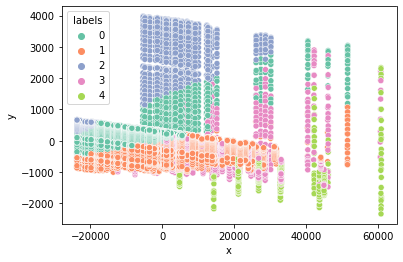

In [ ]:
df_cluster1_4 = fractal_clustering(maryland_sd_inertia_6states_filtered, cluster_label=4,n_clusters=5)
print(df_cluster1_4.shape)

for label in df_cluster1_4.cluster.unique():
  print("label", label, "  shape",df_cluster1_4[df_cluster1_4.cluster == label].shape)

In [ ]:
df_cluster1_4['cluster_label'] = df_cluster1_4['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_4_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final20 = df_cluster1_4[(df_cluster1_4['cluster'] == 2) | (df_cluster1_4['cluster'] == 3) | (df_cluster1_4['cluster'] == 4)]

data_final20.shape

(3936, 47)

### FC :: Cluster 4_0

Cosine kmeans:0.5563266979182524
(7518, 47)
label 4   shape (1138, 47)
label 3   shape (190, 47)
label 0   shape (2691, 47)
label 2   shape (2601, 47)
label 1   shape (898, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



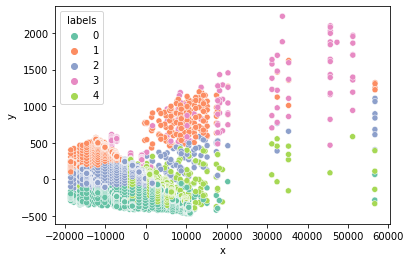

In [ ]:
df_cluster1_4_0 = fractal_clustering(df_cluster1_4, cluster_label=0,n_clusters=5)
print(df_cluster1_4_0.shape)

for label in df_cluster1_4_0.cluster.unique():
  print("label", label, "  shape",df_cluster1_4_0[df_cluster1_4_0.cluster == label].shape)

In [ ]:
df_cluster1_4_0['cluster_label'] = df_cluster1_4_0['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_4_0_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final21 = df_cluster1_4_0.copy()
data_final21.shape

(7518, 47)

### FC :: Cluster 4_2

Cosine kmeans:0.6091028749449685
(1366, 47)
label 0   shape (120, 47)
label 3   shape (607, 47)
label 2   shape (347, 47)
label 1   shape (282, 47)
label 4   shape (10, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



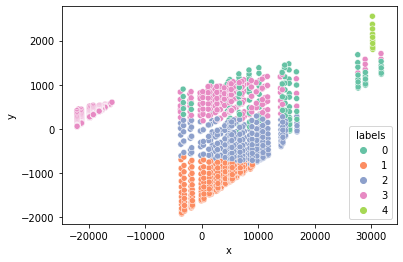

In [ ]:
df_cluster1_4_2 = fractal_clustering(df_cluster1_4, cluster_label=2,n_clusters=5)
print(df_cluster1_4_2.shape)

for label in df_cluster1_4_2.cluster.unique():
  print("label", label, "  shape",df_cluster1_4_2[df_cluster1_4_2.cluster == label].shape)

In [ ]:
df_cluster1_4_2['cluster_label'] = df_cluster1_4_2['cluster'].apply(lambda x: rename_cluster_label(x,'cluster_4_2_'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_final22 = df_cluster1_4_2.copy()

## Concatenate all labeled cluster results

In [ ]:
dataframes = [data_final1,data_final2,data_final3,data_final4,data_final5,data_final6,
              data_final7,data_final8,data_final9,data_final10,data_final11,data_final12,data_final13,
              data_final14,data_final15,data_final16,data_final17,data_final18,data_final19,
              data_final20,data_final21,data_final22]

In [ ]:
final_data = pd.concat(dataframes)
final_data.shape

(129545, 47)

In [ ]:
maryland_sd_inertia_6states_filtered.shape

(139769, 47)

In [ ]:
139769 - 129545

10224

### Saving to csv

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/'
filename = 'Maryland_inertia_MobilityClusterlabeled_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
final_data.to_csv(location+filename,index=False)

Maryland_inertia_clusterlabeled_Oct23.csv


## Idea

16 clusters

* filter each cluster df[] min and max of [new cases /1000k]

* 16 min ,16 max
* actual max(max(16 clusters) , actual min(min(16 clusters))

* what is the min new cases in the actual max cluster?

max new cases = 20. [cluster 5]
min new cases = 0.0001 [cluster 5]
* -We ensure, we don't land on the above situation. [[[important]]


* what is the min new cases in the actual min cluster?

- validate proper cluster for min and max cluster

* finding the feature ranking (correlation, pair plot...) 
* **Goal**: Find relation between our factors and new cases.





* If you find 4 clusters 